In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), os.pardir, 'src')) 

In [2]:
from data.extraction import Data
from models.train_model import LinearDependency, Profiler

# Extract, Transform, Load (ETL)

        Applied principles: 
        Dimensionality reduction (removed duplicated features), 
        Optimized performance: Optimized size of data (int -> category)
        Converted text classes to categorical codes
        Data normalization
        Data cleaning (nan treatment, feature values: str -> float)
        Data sorted by dtype (for easier data manipulation)

In [3]:
data = Data()

In [4]:
data.extract('raw', 'reto_precios.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   main_name             981 non-null    object 
 1   subtitle              981 non-null    object 
 2   link                  981 non-null    object 
 3   location              981 non-null    object 
 4   price                 981 non-null    object 
 5   attributes            981 non-null    object 
 6   timestamp             981 non-null    object 
 7   id                    981 non-null    int64  
 8   address               702 non-null    object 
 9   since                 981 non-null    object 
 10  description           981 non-null    object 
 11  vendor                981 non-null    object 
 12  lat                   981 non-null    float64
 13  lon                   981 non-null    float64
 14  price_mod             981 non-null    float64
 15  price_currency        9

In [5]:
df = data.remove_duplicated_features(df=data.raw.copy())

In [6]:
df = data.fix_nans(df)

In [7]:
df = data.fix_monthly_fee(df)

In [8]:
categorical_features = ['vendor',
                        'since_period',
                        'disposition',
                        'orientation',
                        'department_type']
df = data.get_cat_codes(df, categorical_features=categorical_features)

In [9]:
df = data.sort_df_dtype(df)

In [10]:
df = data.normalize_features(df)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   since_period          981 non-null    float64
 1   disposition           981 non-null    float64
 2   orientation           981 non-null    float64
 3   department_type       981 non-null    float64
 4   since_value           981 non-null    float64
 5   monthly_fee           981 non-null    float64
 6   parking_lots          981 non-null    float64
 7   lat                   981 non-null    float64
 8   lon                   981 non-null    float64
 9   days_on_site          981 non-null    float64
 10  amenities             981 non-null    float64
 11  bathrooms             981 non-null    float64
 12  cellars               981 non-null    float64
 13  num_floors            981 non-null    float64
 14  apartments_per_floor  981 non-null    float64
 15  floor_situated        9

# Exploratory Data Analysis (EDA) Part 1/2

    Clustering of departments for sale, data distribution, visualizations.

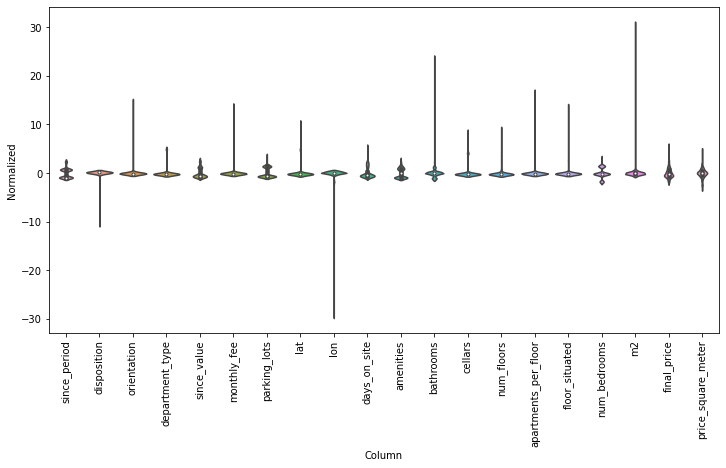

In [13]:
# Data distribution, among other things it allows you to easily spot the existence of outliers.
data.get_data_distribution(df)

In [47]:
# Clustering of departments for sale by any two features. 
profile = Profiler(data.raw)
features = ['m2', 'final_price']
profile.classify(features, n_clusters=8)
profile.plot(x='m2', y='final_price', color='class', size='final_price')

In [14]:
# Once the function parameters have been set we can visualize price_square_meter vs some_feature.

# Feature engineering

In [15]:
#Download external data. Engineer new features. 

### Geocoding web service

    Used to correctly extract the location data. Since we have the (lat, lon) coordinates we can find the address attributes. 
    It is better this way, because the first record in our dataset has an incorrect neighbourhood "Roma Sur". 
    The correct neighbourhood is "Roma Norte" since "Calle Sinaloa 20" is located in the neighbourhood "Roma Norte".

In [16]:
#Download and save geospatial data
#location_data = data.get_location_attributes(data.raw)
#Read and load previously downloaded data
location_data = data.read_location_attributes()
# Add external data to dataset
df = data.add_location_attributes(df, location_data)

### Índice de Desarrollo Social de la Ciudad de México, 2020 

    Es una medida ponderada que integra las dimensiones de vivienda, 
    acceso a servicios sanitarios (agua, drenaje y excusado), 
    adecuación energética, acceso a internet y disponibilidad de telefonía (fija o celular), 
    así como el rezago educativo, el acceso a los servicios de salud y a la seguridad social.

In [17]:
df = data.add_idsm(df)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ids                   981 non-null    float64
 1   road                  981 non-null    object 
 2   neighbourhood         981 non-null    object 
 3   postcode              981 non-null    object 
 4   mayoralty             981 non-null    object 
 5   city                  981 non-null    object 
 6   state                 981 non-null    object 
 7   country               981 non-null    object 
 8   since_period          981 non-null    float64
 9   disposition           981 non-null    float64
 10  orientation           981 non-null    float64
 11  department_type       981 non-null    float64
 12  since_value           981 non-null    float64
 13  monthly_fee           981 non-null    float64
 14  parking_lots          981 non-null    float64
 15  lat                   9

# Model

In [19]:
# We will use a linear regresion model. It is a simple model that allows to compute price_per_square as a function of all available features. It will also allow us to see the distribution of weights associated with each feature.

### Before external data

In [20]:
train_df = df.iloc[:, 8:-1]
target_df = df.iloc[:, -1:]

In [21]:
linear = LinearDependency(train_df=train_df, target_df=target_df)

In [22]:
linear.compile_and_fit(model=linear.model, model_name='linear')

Epoch 1/100
31/31 [==============================] - 0s 500us/step - loss: 2.3291 - mean_absolute_error: 1.0160
Epoch 2/100
31/31 [==============================] - 0s 467us/step - loss: 2.1966 - mean_absolute_error: 0.9808
Epoch 3/100
31/31 [==============================] - 0s 467us/step - loss: 2.0792 - mean_absolute_error: 0.9477
Epoch 4/100
31/31 [==============================] - 0s 400us/step - loss: 1.9711 - mean_absolute_error: 0.9176
Epoch 5/100
31/31 [==============================] - 0s 433us/step - loss: 1.8731 - mean_absolute_error: 0.8894
Epoch 6/100
31/31 [==============================] - 0s 400us/step - loss: 1.7842 - mean_absolute_error: 0.8636
Epoch 7/100
31/31 [==============================] - 0s 433us/step - loss: 1.7013 - mean_absolute_error: 0.8396
Epoch 8/100
31/31 [==============================] - 0s 433us/step - loss: 1.6278 - mean_absolute_error: 0.8170
Epoch 9/100
31/31 [==============================] - 0s 433us/step - loss: 1.5563 - mean_absolute_error:

31/31 [==============================] - 0s 433us/step - loss: 0.5712 - mean_absolute_error: 0.5516
Epoch 74/100
31/31 [==============================] - 0s 433us/step - loss: 0.5696 - mean_absolute_error: 0.5515
Epoch 75/100
31/31 [==============================] - 0s 433us/step - loss: 0.5676 - mean_absolute_error: 0.5510
Epoch 76/100
31/31 [==============================] - 0s 400us/step - loss: 0.5661 - mean_absolute_error: 0.5506
Epoch 77/100
31/31 [==============================] - 0s 433us/step - loss: 0.5651 - mean_absolute_error: 0.5508
Epoch 78/100
31/31 [==============================] - 0s 433us/step - loss: 0.5625 - mean_absolute_error: 0.5497
Epoch 79/100
31/31 [==============================] - 0s 467us/step - loss: 0.5608 - mean_absolute_error: 0.5491
Epoch 80/100
31/31 [==============================] - 0s 433us/step - loss: 0.5600 - mean_absolute_error: 0.5491
Epoch 81/100
31/31 [==============================] - 0s 433us/step - loss: 0.5581 - mean_absolute_error: 0.5

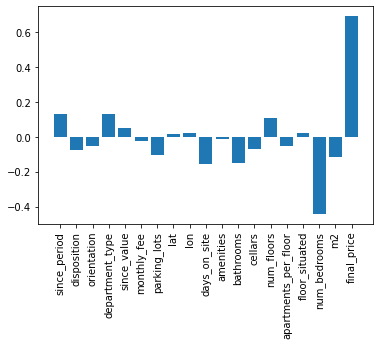

In [23]:
linear.plot_weights()

### After external data

In [24]:
categorical_features = ['ids','road',
                            'neighbourhood',
                            'postcode',
                            'mayoralty',
                            'city',
                            'state']
df = data.get_cat_codes(df, categorical_features=categorical_features)

In [25]:
df = data.sort_df_dtype(df)

In [26]:
df = data.normalize_features(df)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ids                   981 non-null    float64
 1   road                  981 non-null    float64
 2   neighbourhood         981 non-null    float64
 3   postcode              981 non-null    float64
 4   mayoralty             981 non-null    float64
 5   city                  981 non-null    float64
 6   state                 981 non-null    float64
 7   since_period          981 non-null    float64
 8   disposition           981 non-null    float64
 9   orientation           981 non-null    float64
 10  department_type       981 non-null    float64
 11  since_value           981 non-null    float64
 12  monthly_fee           981 non-null    float64
 13  parking_lots          981 non-null    float64
 14  lat                   981 non-null    float64
 15  lon                   9

In [28]:
train_df = df.iloc[:, :-1]
target_df = df.iloc[:, -1:]

In [29]:
linear = LinearDependency(train_df=train_df, target_df=target_df)

In [30]:
linear.compile_and_fit(model=linear.model, model_name='linear')

Epoch 1/100
31/31 [==============================] - 0s 433us/step - loss: 2.7793 - mean_absolute_error: 1.2205
Epoch 2/100
31/31 [==============================] - 0s 433us/step - loss: 2.4858 - mean_absolute_error: 1.1497
Epoch 3/100
31/31 [==============================] - 0s 433us/step - loss: 2.2360 - mean_absolute_error: 1.0901
Epoch 4/100
31/31 [==============================] - 0s 433us/step - loss: 2.0226 - mean_absolute_error: 1.0371
Epoch 5/100
31/31 [==============================] - 0s 433us/step - loss: 1.8462 - mean_absolute_error: 0.9904
Epoch 6/100
31/31 [==============================] - 0s 433us/step - loss: 1.6836 - mean_absolute_error: 0.9480
Epoch 7/100
31/31 [==============================] - 0s 467us/step - loss: 1.5481 - mean_absolute_error: 0.9067
Epoch 8/100
31/31 [==============================] - 0s 433us/step - loss: 1.4289 - mean_absolute_error: 0.8711
Epoch 9/100
31/31 [==============================] - 0s 433us/step - loss: 1.3249 - mean_absolute_error:

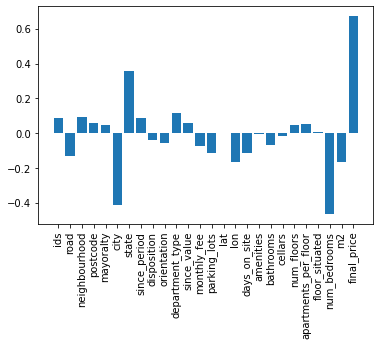

In [31]:
linear.plot_weights()

# Exploratory Data Analysis (EDA) Part 2/2

In [65]:
profile = Profiler(df)
size = (profile.ds - profile.ds.min())  / (profile.ds.max() - profile.ds.min())
features = ['m2', 'final_price']
profile.classify(features, n_clusters=8)
profile.plot(x='final_price', y='num_bedrooms', color='class', size=size['final_price'])

In [39]:
data.raw['description'][2]

'Concepto único en Roma Sur, es un desarrollo de 4 townhouses en 3 niveles más roof garden privado.Increíble ubicación con todo tipo de servicios a menos de 20 minutos caminando: restaurantes, parques, supermercados, etc. además de toda la vida de la colonia Roma. Acabados de última generación: en concreto aparente, mármol y madera.En planta baja cuenta con una amplia estancia con terraza y un pequeño balcón en la cocina y medio baño para visitas; en el primer nivel están dos recámaras con clóset cada una y que comparten un baño completo y el área de lavado; en el segundo nivel se encuentra la recámara principal con amplio baño y un estudio de T.V.; por último un piso más arriba está el roof garden privado de este departamento. Cuenta con dos bodegas y dos estacionamientos con elevaautos'

# Future work

Design and implement a Recurrent Neural Network (RNN) to classify property description. 

Design and Implement a Convolutional Neural Network (CNN) to classify property images.